# 【A/B测试】支付宝营销策略效果分析

A/Btest常用于比较不同的设计、运营方案的优劣，以辅助决策。本分析以支付宝营销活动为例，通过广告点击率指标比较两组营销策略的广告投放效果。

## 1 数据来源

本文所用的数据集来源于阿里云天池：https://tianchi.aliyun.com/dataset/dataDetail?dataId=50893&lang=zh-cn

该数据集包含三张表(数据量100万)，分别记录了支付宝两组营销的活动情况：
- emb_tb_2.csv: 用户特征数据集
- effect_tb.csv: 广告点击情况数据集
- seed_cand_tb.csv: 用户类型数据集

本分析报告的主要使用广告点击情况数据，涉及字段如下：
- dmp_id：营销策略编号（源数据文档未作说明，这里根据数据情况设定为1：对照组，2：营销策略一，3：营销策略二）
- user_id：支付宝用户ID
- label：用户当天是否点击活动广告（0：未点击，1：点击）

## 2 数据处理

### 2.1 数据导入和清洗

#### 1. 导入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('effect_tb.csv',header = None)
data.columns = ['dt','user_id','label','dmp_id']

# 日志天数属性用不上，删除该列
data = data.drop(columns='dt')
data.head(3)

,user_id,label,dmp_id
0,1,0,1
1,1000004,0,1
2,1000004,0,2


In [3]:
data.shape

(2645958, 3)

#### 2. 总览数据概况

In [4]:
#通过info()来熟悉数据类型
data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645958 entries, 0 to 2645957
Data columns (total 3 columns):
user_id    2645958 non-null int64
label      2645958 non-null int64
dmp_id     2645958 non-null int64
dtypes: int64(3)
memory usage: 60.6 MB


从这里可看出数据类型正常，并且无缺失值

In [5]:
#通过describe()来熟悉数据的相关统计量
data.describe()

,user_id,label,dmp_id
count,2.645958e+06,2.645958e+06,2.645958e+06
mean,3.112995e+06,1.456297e-02,1.395761e+00
std,1.828262e+06,1.197952e-01,6.920480e-01
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.526772e+06,0.000000e+00,1.000000e+00
50%,3.062184e+06,0.000000e+00,1.000000e+00
75%,4.721132e+06,0.000000e+00,2.000000e+00
max,6.265402e+06,1.000000e+00,3.000000e+00


#### 3. 判断数据重复情况

- nunique() 可直接统计dataframe中每列的不同值的个数,也可用于series,但不能用于list.返回的是不同值的个数.

In [6]:
# distinct count of columns
data.nunique()

user_id    2410683
label            2
dmp_id           3
dtype: int64

这里发现，数据行与独立用户数不统一，下面检查是否存在重复行

In [7]:
# 查找重复项
data[data.duplicated(keep = False)].sort_values(by = ["user_id"]) # 设置keep = False会将所有重复的项都显示出来

,user_id,label,dmp_id
8529,1027,0,1
1485546,1027,0,1
1579415,1471,0,1
127827,1471,0,1
404862,2468,0,1
...,...,...,...
1382121,6264633,0,1
1382245,6264940,0,1
2575140,6264940,0,1
1382306,6265082,0,3


In [8]:
# 删除重复项
data = data.drop_duplicates()

# 检查是否还有重复项
data[data.duplicated(keep = False)]

,user_id,label,dmp_id


#### 4. 判断数据缺失情况


In [9]:
data.isnull().sum()

user_id    0
label      0
dmp_id     0
dtype: int64

可以看出数据并无缺失情况

#### 5. 判断数据异常情况

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2632975 entries, 0 to 2645957
Data columns (total 3 columns):
user_id    int64
label      int64
dmp_id     int64
dtypes: int64(3)
memory usage: 80.4 MB


从这里看出数据类型正常，下面用透视表查看各属性字段是否存在不合理取值

In [11]:
data.pivot_table(index = 'dmp_id',columns = 'label',values = 'user_id',aggfunc = 'count',margins = True) # margins = True表示添加所有行列的总计

label,0,1,All
dmp_id,,,
1,1881745,23918,1905663
2,404811,6296,411107
3,307923,8282,316205
All,2594479,38496,2632975


从以上看出属性字段无异常取值，无需进行处理

### 2.2 样本容量检验

在进行A/B测试前，需检查样本容量是否满足试验所需最小值。

这里借助Evan Miller的样本量计算工具：https://www.evanmiller.org/ab-testing/sample-size.html

首先需要设定点击率基准线以及最小提升比例，我们将对照组的点击率设为基准线.

In [12]:
# 控制组的点击率
data[data["dmp_id"] == 1]["label"].mean()

0.012551012429794775

对照组的点击率为1.26%，假设我们希望新的营销策略能够让广告点击率至少提升一个百分点，则算得所需最小样本量为2167.
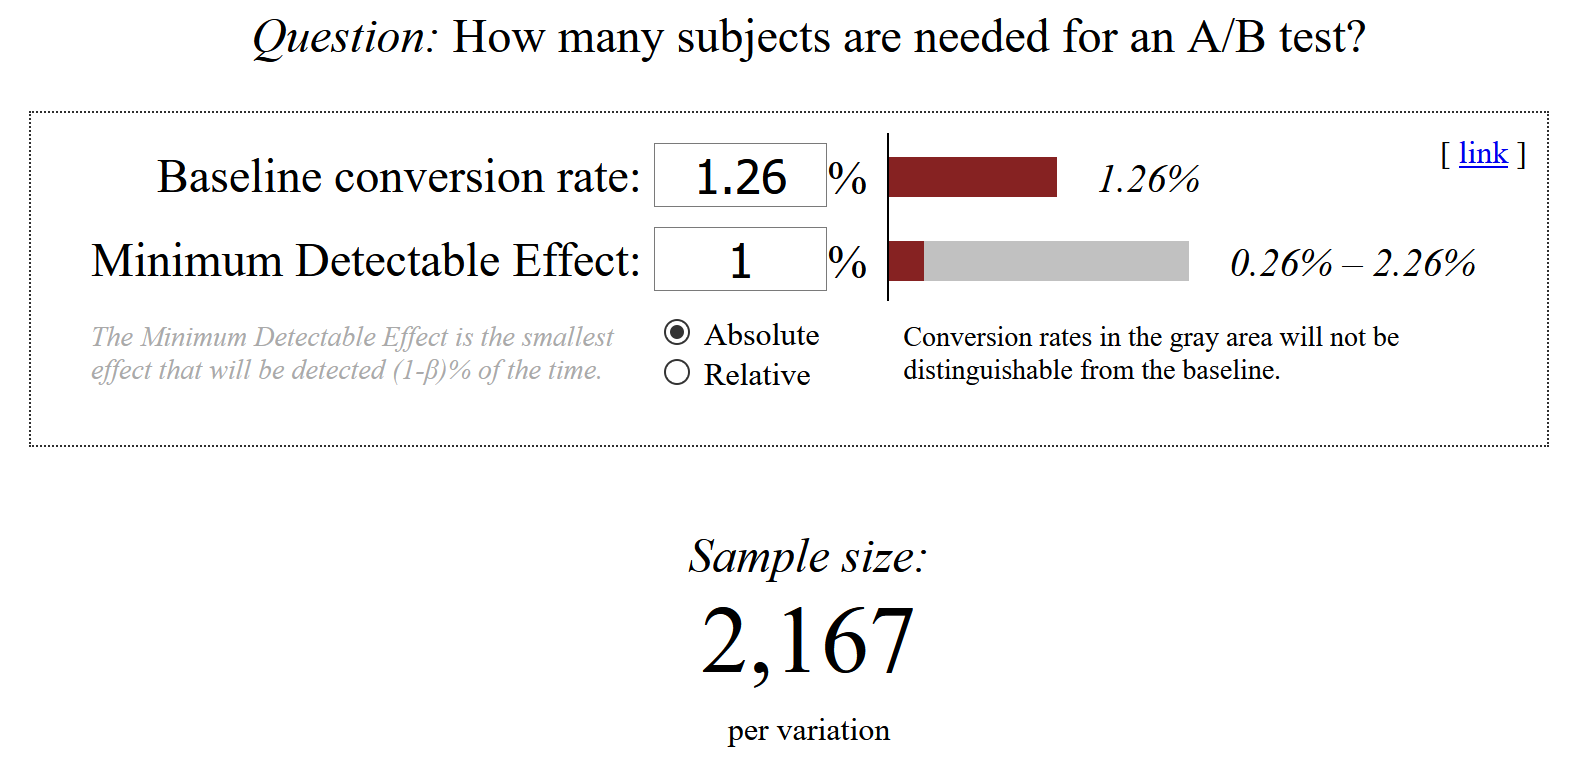

In [13]:
# 广告活动样本数量
data["dmp_id"].value_counts()

1    1905663
2     411107
3     316205
Name: dmp_id, dtype: int64

两组营销活动的样本量分别为41.11万和31.62万，满足最小样本量需求。

In [14]:
# 保存清洗好的数据备用
# save it to file
data.to_csv("output.csv", index = False)

In [15]:
# 重新加载数据
# data = pd.read_csv("data/output.csv")

## 3 假设检验

先观察几组试验的点击率情况。

In [16]:
# 几组数据的点击率
print("对  照  组： " ,data[data["dmp_id"] == 1]["label"].mean())
print("营销策略一： " ,data[data["dmp_id"] == 2]["label"].mean())
print("营销策略二： " ,data[data["dmp_id"] == 3]["label"].mean())

对  照  组：  0.012551012429794775
营销策略一：  0.015314747742072015
营销策略二：  0.026191869198779274


可以看到策略一和策略二相比对照组在点击率上都有不同程度的提升。

其中策略一提升0.2个百分点，策略二提升1.3个百分点，只有策略二满足了前面我们对点击率提升最小值的要求。

接下来需要进行假设检验，看策略二点击率的提升是否显著。

**a. 零假设和备择假设**

    记对照组点击率为p1，策略二点击率为p2，则：
    零假设 H0： p1>=p2，即p1-p2>=0
    备择假设 H1： p1<p2，即p1-p2<0
    
**b. 检验方向**

    根据备择假设，确定检验反向为单侧（左尾）
    
**c. 分布类型、检验类型和显著性水平**

    样本服从二项分布（二点分布），独立双样本，样本大小n＞30，总体均值和标准差未知，所以采用Z检验。检验统计量为：
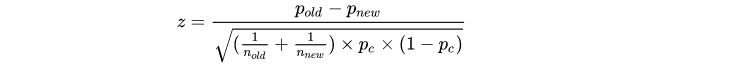
    
                                               其中，Pc为总和点击率（点击率的联合估计）
    显著性水平α取0.05。

### 3.1 方法一：公式计算

In [17]:
# 用户数
n_old = len(data[data.dmp_id == 1])  # 对照组
n_new = len(data[data.dmp_id == 3])  # 策略二

# 点击数
c_old = len(data[data.dmp_id ==1][data.label == 1])
c_new = len(data[data.dmp_id ==3][data.label == 1])

# 计算点击率
p_old = c_old / n_old
p_new = c_new / n_new

# 总和点击率（点击率的联合估计）
p_c = (c_old + c_new) / (n_old + n_new)

print("总和点击率：", p_c)

总和点击率： 0.014492310074225832


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [18]:
# 计算检验统计量z
z = (p_old - p_new) / np.sqrt(p_c * (1 - p_c)*(1/n_old + 1/n_new))

print("检验统计量z：", z)

检验统计量z： -59.44168632985996


In [19]:
# 查α=0.05对应的z分位数,注意备择假设是左尾（单侧）
from scipy.stats import norm
z_alpha = norm.ppf(0.05)
# 若为双侧，则norm.ppf(0.05/2)
z_alpha

-1.6448536269514729

z_alpha = -1.64， 检验统计量z = -59.44，该检验为左侧单尾检验，拒绝域为{z＜z_alpha}，z=-59.44落在拒绝域。

所以我们可以得出结论：在显著性水平为0.05时，拒绝原假设，策略二点击率的提升在统计上是显著的。

假设检验并不能真正的衡量差异的大小，它只能判断差异是否比随机造成的更大。因此，我们在报告假设检验结果的同时，应给出效应的大小。对比平均值时，衡量效应大小的常见标准之一是Cohen'd，中文一般翻译作科恩d值：
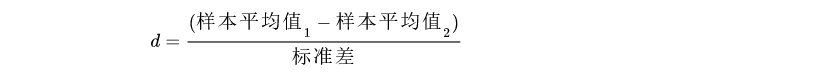

这里的标准差，由于是双独立样本的，需要用合并标准差（pooled standard deviations）代替。也就是以合并标准差为单位，计算两个样本平均值之间相差多少。双独立样本的合并标准差可以如下计算：
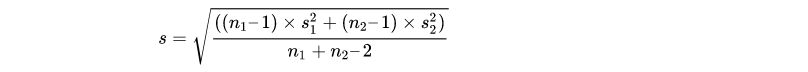
其中s是合并标准差，n1和n2是第一个样本和第二个样本的大小，s1和s2是第一个和第二个样本的标准差。减法是对自由度数量的调整。

In [22]:
# 合并标准差
std_old = data[data.dmp_id ==1].label.std()
std_new = data[data.dmp_id ==3].label.std()
s = np.sqrt(((n_old - 1)* std_old**2 + (n_new - 1)* std_new**2 ) / (n_old + n_new - 2))
# 效应量Cohen's d
d = (p_old - p_new) / s
print('Cohen\'s d为：', d)

Cohen's d为： -0.11423211767803992


一般上baiCohen's d取值0.2-0.5为小效应，0.5-0.8中等效应，0.8以上为大效应。

### 3.2 方法二：Python函数计算

直接用python statsmodels包计算z值和p值，参考官方文档https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html#statsmodels.stats.proportion.proportions_ztest

In [24]:
import statsmodels.stats.proportion as sp
# alternative='smaller'代表左尾
z_score, p = sp.proportions_ztest([c_old, c_new], [n_old,n_now], alternative = "smaller")
print("检验统计量z：",z_score,"，p值：", p)

检验统计量z： -59.44168632985996 ，p值： 0.0


用p值判断与用检验统计量z判断是等效的，这里p值约等于0.016，同样也拒绝零假设。

至此，我们可以给出报告：

- 对照组的点击率为：0.0126，标准差为：0.11
- 策略二的点击率为：0.0262，标准差为：0.16
- 独立样本z=-59.44，p=0，单尾检验（左尾），拒绝零假设。
- 效应量Cohen's d=  -0.11，较小。

根据前面案例，我们用的是两个比率的z检验函数proportion.proportions_ztest，输入的是两组各自的总数和点击率；如果是一般性的z检验，可以用weightstats.ztest函数，直接输入两组的具体数值，可参考https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html

In [35]:
import statsmodels.stats.weightstats as sw
z_score1, p_value1 = sw.ztest(data[data.dmp_id ==1].label, data[data.dmp_id ==3].label, alternative='smaller')
print('检验统计量z:', z_score1, '，p值:', p_value1)

检验统计量z: -59.48897941747809 ，p值: 0.0


可以看到计算结果很接近，但是有点差异。因为非比率的z检验是不计算联合估计的。

作为补充，我们再检验下策略一的点击率提升是否显著。

In [28]:
# 策略一检验
z_score, p = sp.proportions_ztest([c_old, len(data[data.dmp_id ==2][data.label == 1])],[n_old, len(data[data.dmp_id ==2])], alternative = "smaller")
print('检验统计量Z:',z_score,',p值：',p)

检验统计量Z: -14.165873564308429 ,p值： 7.450121742737582e-46


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


p值约为 7.450121742737582e-46，p<α,但是因为前面我们设置了对点击率提升的最小要求（1%），这里仍然只选择第二组策略进行推广。

### 3.3 方法三：蒙特卡洛法模拟

蒙特卡洛法其实就是模拟法，用计算机模拟多次抽样，获得分布。

在零假设成立（p_old>=p_new）的前提下， p_old=p_new 为临界情况（即零假设中最接近备择假设的情况）。如果连相等的情况都能拒绝，那么零假设的剩下部分（ p_old>p_new）就更能够拒绝了。

定义effect_tb.csv中样本的总点击率为 p_all：

In [38]:
p_all = data.label.mean()
print('p_all:', p_all)

p_all: 0.014620723706073927


我们进行一次模拟，以 p_all 为对照组和策略二共同的点击率，即取p_old=p_new=p_all，分别进行n_old次和n_new次二点分布的抽样，使模拟的样本大小同effect_tb.csv中的样本大小相同：

In [39]:
old_page = np.random.choice(2, size=n_old, p=[1-p_all, p_all])
new_page = np.random.choice(2, size=n_new, p=[1-p_all, p_all])
diff = old_page.mean() - new_page.mean()
print('对照组结果：', old_page, '，策略二结果：', new_page, '，模拟的转化率差值：', diff)

对照组结果： [0 0 0 ... 0 0 0] ，策略二结果： [0 0 0 ... 0 0 0] ，模拟的转化率差值： -0.00014255723210187046


因为是随机抽样，所以每次模拟的点击率差值也是不同的，多运行几次就会发现，我们模拟出的结果很难比effect_tb.csv中样本的点击率差值更小，这说明了什么？

In [41]:
# 计算effect_tb.csv样本的点击率差值
data_diff = data[data["dmp_id"] == 1]["label"].mean()-data[data["dmp_id"] == 3]["label"].mean()
print('ab_data.csv样本的点击率差值:', data_diff)

ab_data.csv样本的转化率差值: -0.0136408567689845


按照如上方式进行多次模拟，这里我们进行10000次，并计算出每个样本得到的策略点击率差值，将其存储在diffs中：

In [40]:
diffs=[]
for i in range(10000):
    p_new_diff = np.random.choice(2,size=n_new,p=[1-p_all,p_all]).mean()
    p_old_diff = np.random.choice(2,size=n_old,p=[1-p_all,p_all]).mean()
    diffs.append(p_old_diff - p_new_diff)

实际上每次模拟都得到了一个大小为316205的样本，此处得到了10000个样本。在图上将模拟得到的diffs绘制为直方图，将effect_tb.csv中样本的点击率差值绘制为竖线：

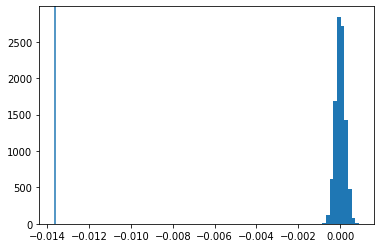

In [43]:
diffs = np.array(diffs)
plt.hist(diffs)
plt.axvline(data_diff)

在diffs列表的数值中，有多大比例小于effect_tb.csv中观察到的点击率率差值？

In [45]:
(diffs < data_diff).mean()

0.0

本次方法得到的答案是0,和方法二中的P值接近（一样）。

上图的含义是，在p_old=p_new时，进行10000次模拟得到的差值中，0%的可能比effect_tb.csv中的差值更极端，说明effect_tb.csv在p_old=p_new的前提是很小概率（这次是0概率）事件。反过来说，我们只做了一次A/B测试就得到了零假设中的极端情况，则零假设很有可能是不成立的。

- 现在图中的直方图是，若对照组和策略二的点击率相等，随机10000次，两者的差值的分布。
- 因为次数够多，根据大数定律，近似于真实的分布。
- 越靠近中间的部分，说明该数值出现的次数越多，越靠近两侧，说明该数值出现的越少，也可以说情况就越极端。
- 竖线是样本effect_tb.csv的差值所在位置，它落在了很左侧，体现在竖线左侧的面积（这次为0）很小。
- 竖线左侧的面积占比，即发生“竖线及竖线左侧极端情况”（diff<=-0.014）的可能性。
- 也就是说，effect_tb.csv这个样本，在对照组和策略二点击率相等的情况下，有可能出现，但出现的可能性很小（这次为0）。
- 所以反推出，对照组和策略二的点击率很有可能不相等。

**思考：**

若diffs的分布就是标准正态（这里只是近似），则竖线左侧的面积占比其实就是p值（左侧or右侧or双侧要根据备择假设给定的方向），那**p值到底要多小才算真的小？**

这需要我们自己给定一个标准，这个标准其实就是 α，是犯第一类错误的**上界**，常见的取值有0.1、0.05、0.01。

- 所谓第一类错误，即拒真错误，也就是零假设为真，我们却拒绝了。所以要取定一个 α ，并规定当p值小于 α 时，认为原假设在该显著性水平下被拒绝。
- 还有第二类错误——取伪，即零假设明明是错的，但是我们保留了零假设。拒真的可能性越小，则取伪的可能性越大。所以不能一味地取极小的α 。

**参考链接**：[一文入门A/B测试（含流程、原理及示例）](https://zhuanlan.zhihu.com/p/68019926)

## 4 结论

通过三种方法的计算得出，在两种营销策略中，策略二对广告点击率有显著提升效果，且相较于对照组点击率提升了近一倍，因而在两组营销策略中应选择第二组进行推广。